In [5]:
import os, sys, gc, warnings 
import logging, math, re 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import display, HTML 
from IPython.core.interactiveshell import InteractiveShell
# from sklearn.model_selection import train_test_split
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import download
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

InteractiveShell.ast_node_interactivity = "all" 
display(HTML(data=""""""))

STOPWORDS = set(stopwords.words('english'))


# file_path = 'ADHD CLASSIFIED 18k.csv'


# df = pd.read_csv(file_path, encoding='latin1', delimiter=',')


# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Save the training and testing datasets to separate CSV files with 'latin1' encoding
# train_df.to_csv('train_data.csv', index=False, encoding='latin1')
# test_df.to_csv('test_data.csv', index=False, encoding='latin1')

train = pd.read_csv('train_data.csv',encoding='latin-1', delimiter=',')
test = pd.read_csv('test_data.csv',encoding='latin-1', delimiter=',')

train['split'] = 'train'
test['split'] = 'test'

df_raw = pd.concat([
    train[['Sentence','Label','split']],
    test[['Sentence','Label','split']]],
    axis=0).reset_index(drop=True)

df_raw.shape
df_raw.describe()

df_raw['split'].value_counts()/df_raw.shape[0]*100

df_raw['Label'].value_counts()

def classes_def(x):
    if x ==  "Yes": return "1"
    elif x == "No": return "0"
   
    
df_raw['label'] = df_raw['Label'].apply(lambda x:classes_def(x))
df_raw['label'].value_counts()/df_raw.shape[0]*100

#============CLEAN UP FUNCTIONS===============#
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def lower(text):
    low_text= text.lower()
    return low_text

def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove


def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text

def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove






[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

(17708, 3)

,Sentence,Label,split
count,17708,17708,17708
unique,15617,2,2
top,let's get a little group support going in here...,Yes,train
freq,7,9829,14166


split
train    79.997741
test     20.002259
Name: count, dtype: float64

Label
Yes    9829
No     7879
Name: count, dtype: int64

label
1    55.505986
0    44.494014
Name: count, dtype: float64

In [6]:
df_raw['text_clean'] = df_raw['Sentence'].apply(lambda x:remove_urls(x))
df_raw['text_clean'] = df_raw['text_clean'].apply(lambda x:remove_html(x))
df_raw['text_clean'] = df_raw['text_clean'].apply(lambda x:lower(x))
df_raw['text_clean'] = df_raw['text_clean'].apply(lambda x:remove_num(x))
df_raw['text_clean'] = df_raw['text_clean'].apply(lambda x:punct_remove(x))
df_raw['text_clean'] = df_raw['text_clean'].apply(lambda x:remove_stopwords(x))
df_raw['text_clean'] = df_raw['text_clean'].apply(lambda x:remove_mention(x))
df_raw['text_clean'] = df_raw['text_clean'].apply(lambda x:remove_hash(x))
df_raw['text_clean'] = df_raw['text_clean'].apply(lambda x:remove_space(x))

df_raw_req = df_raw[['text_clean','label','split']]
df_raw_req = df_raw_req.reset_index(drop=True)

df_raw_req.head()


,text_clean,label,split
0,anyone fid hard growing even make friends girl...,1,train
1,weeks finish university huge essays write cann...,1,train
2,im fucking pissed right need tell guys experie...,1,train
3,hey guys dont know anyone else problem thought...,1,train
4,like feel exactly beloved graham,0,train


In [7]:
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()


def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df_raw_req['text_clean'] = df_raw_req['text_clean'].apply(stem_sentences)

def lemmatize_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df_raw_req['text_clean'] = df_raw_req['text_clean'].apply(lemmatize_sentences)

df_raw_req.head()



,text_clean,label,split
0,anyon fid hard grow even make friend girl anyo...,1,train
1,week finish univers huge essay write cannot fo...,1,train
2,im fuck piss right need tell guy experienc tal...,1,train
3,hey guy dont know anyon el problem thought id ...,1,train
4,like feel exactli belov graham,0,train


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split

X = df_raw_req["text_clean"]
bag_of_words = TfidfVectorizer(stop_words="english", use_idf=True)
X_tfidf = bag_of_words.fit_transform(X)  

svd = TruncatedSVD(n_components=10, algorithm="arpack")
tfidf_lsa_data = svd.fit_transform(X_tfidf)

index_train = df_raw_req[(df_raw_req['split']=='train')].index.values
index_test = df_raw_req[(df_raw_req['split']=='test')].index.values

svd_bow_X_train = tfidf_lsa_data[index_train]
svd_bow_X_test = tfidf_lsa_data[index_test]
y_train = df_raw_req.loc[index_train]['label'].values
y_test = df_raw_req.loc[index_test]['label'].values

print(f'Shape of train X - {svd_bow_X_train.shape}')
print(f'Shape of test X - {svd_bow_X_test.shape}')
print(f'Shape of train y - {y_train.shape}')
print(f'Shape of test y - {y_test.shape}')


Shape of train X - (14166, 10)
Shape of test X - (3542, 10)
Shape of train y - (14166,)
Shape of test y - (3542,)


In [ ]:
svd_bow_X_train
y_train

In [ ]:
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score 
from sklearn.calibration import CalibratedClassifierCV 
from sklearn import metrics

results = {}

k_fold = 5

max_iter_runtime = 10**5 
tolerance = 10**(-2)    
model = LinearSVC(dual=False, tol=tolerance, max_iter=max_iter_runtime)
calibrated = CalibratedClassifierCV(base_estimator=model,cv=k_fold)
calibrated.fit(svd_bow_X_train, y_train)
score = calibrated.score(svd_bow_X_test, y_test)
results["SVD_BoW_SVM"] = score

model = LogisticRegression(max_iter=10000)
calibrated = CalibratedClassifierCV(base_estimator=model,cv=k_fold)
calibrated.fit(svd_bow_X_train, y_train)
score = calibrated.score(svd_bow_X_test, y_test)
results["SVD_BoW_LogisticRegression"] = score

model = RandomForestClassifier()
calibrated_rf = CalibratedClassifierCV(base_estimator=model,cv=k_fold)
calibrated_rf.fit(svd_bow_X_train, y_train)
score = calibrated_rf.score(svd_bow_X_test, y_test)
results["SVD_BoW_RandomForest"] = score

results_display = pd.DataFrame.from_dict(results,orient='index')
results_display = results_display.reset_index()
results_display.columns = ['Model','Score']

display(results_display)


CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, max_iter=100000,
                                                tol=0.01),
                       cv=5)

CalibratedClassifierCV(base_estimator=LogisticRegression(max_iter=10000), cv=5)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(), cv=5)

,Model,Score
0,SVD_BoW_SVM,0.942688
1,SVD_BoW_LogisticRegression,0.940994
2,SVD_BoW_RandomForest,0.952005


In [ ]:
predicted = calibrated.predict(svd_bow_X_test)
predicted_prob = calibrated.predict_proba(svd_bow_X_test)

classes = ['Yes','No']
res1, res2 = map(list, zip(*predicted_prob))
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, res1, multi_class="ovr")
print("Accuracy:{:^20}".format(round(accuracy,2)))
print("Auc:{:^30}".format(round(auc,2)))
print("Detail:")
print(metrics.classification_report(y_test, predicted))


Accuracy:        0.94        
Auc:             0.02             
Detail:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1581
           1       0.95      0.95      0.95      1961

    accuracy                           0.94      3542
   macro avg       0.94      0.94      0.94      3542
weighted avg       0.94      0.94      0.94      3542



<Axes: >

[Text(0.5, 23.52222222222222, 'Pred'),
 Text(50.722222222222214, 0.5, 'True'),
 [Text(0.5, 0, 'Yes'), Text(1.5, 0, 'No')],
 [Text(0, 0.5, 'Yes'), Text(0, 1.5, 'No')],
 Text(0.5, 1.0, 'Confusion matrix')]

(array([0.5, 1.5]), [Text(0, 0.5, 'Yes'), Text(0, 1.5, 'No')])

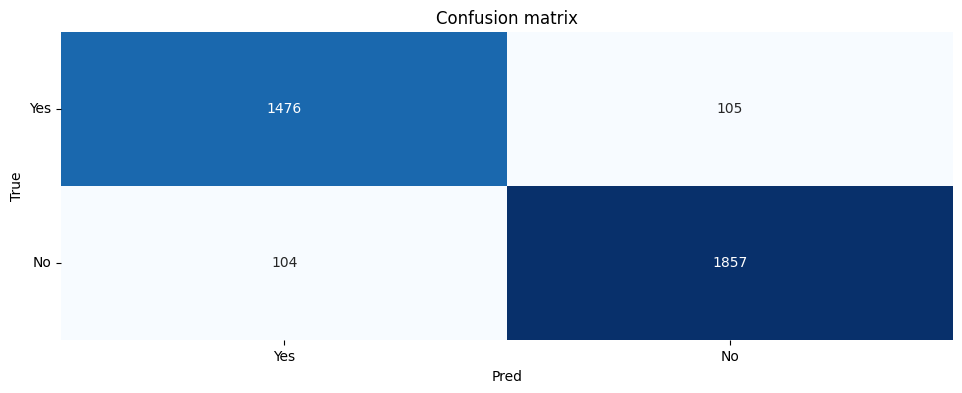

In [ ]:
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.gcf().set_size_inches(11.5, 4)


[(-0.05, 1.0),
 (0.0, 1.05),
 Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate (Recall)'),
 Text(0.5, 1.0, 'Receiver operating characteristic')]

[(0.0, 1.05),
 (0.0, 1.05),
 Text(0.5, 0, 'Recall'),
 Text(0, 0.5, 'Precision'),
 Text(0.5, 1.0, 'Precision-Recall curve')]

(0.0, 1.0)

(0.0, 1.0)

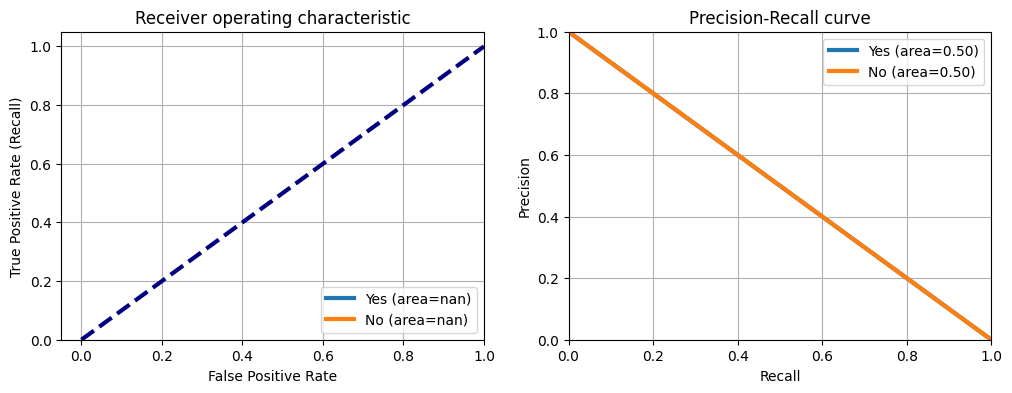

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test,  predicted_prob[:,i],pos_label=1)
    ax[0].plot(fpr, tpr, lw=3, 
label='{0} (area={1:0.2f})'.format(
    classes[i],
    metrics.auc(fpr, tpr))
              )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)


for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, predicted_prob[:,i],pos_label=1)
    ax[1].plot(
        recall, precision, lw=3, 
        label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision))
    )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.gcf().set_size_inches(12, 4)
plt.xlim(0, 1)
plt.ylim(0, 1)
print(end="")


In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier

param_dist = {"max_depth": [2,3,5],
              "max_features": [1,2],
              "min_samples_split":[1,2],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rf = RandomForestClassifier(n_estimators=20)
clf = GridSearchCV(rf, param_dist)
clf.fit(svd_bow_X_train, y_train)

sorted(clf.cv_results_.keys())


GridSearchCV(estimator=RandomForestClassifier(n_estimators=20),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5], 'max_features': [1, 2],
                         'min_samples_split': [1, 2]})

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_bootstrap',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_split',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']